In [ ]:
import pandas as pd
data=pd.read_csv("/content/drive/MyDrive/Time series/top_10_stock_data.csv")
data.head(1)

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,AAPL,27.8475,27.860001,26.8375,27.3325,24.373959,212818400


/tmp/ipython-input-2757588161.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features.fillna(df_features.median(), inplace=True)


Epoch 1/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - loss: 0.0807 - mae: 0.1675 - val_loss: 0.2205 - val_mae: 0.1392
Epoch 2/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 40s 71ms/step - loss: 0.0195 - mae: 0.0889 - val_loss: 0.1768 - val_mae: 0.1192
Epoch 3/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - loss: 0.0153 - mae: 0.0761 - val_loss: 0.1196 - val_mae: 0.1032
Epoch 4/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - loss: 0.0102 - mae: 0.0667 - val_loss: 0.1523 - val_mae: 0.1293
Epoch 5/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - loss: 0.0114 - mae: 0.0657 - val_loss: 0.0935 - val_mae: 0.1094
Epoch 6/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 25s 74ms/step - loss: 0.0114 - mae: 0.0660 - val_loss: 0.0956 - val_mae: 0.0965
Epoch 7/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - loss: 0.0109 - mae: 0.0651 - val_loss: 0.1181 - val_mae: 0.1206
Epoch 8/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - loss: 0.0092 - mae: 0.0606 - val_loss: 0.0752 - val_mae: 0.0917
Epoch 9/100
338/338 ━━━━━━━━━━━━

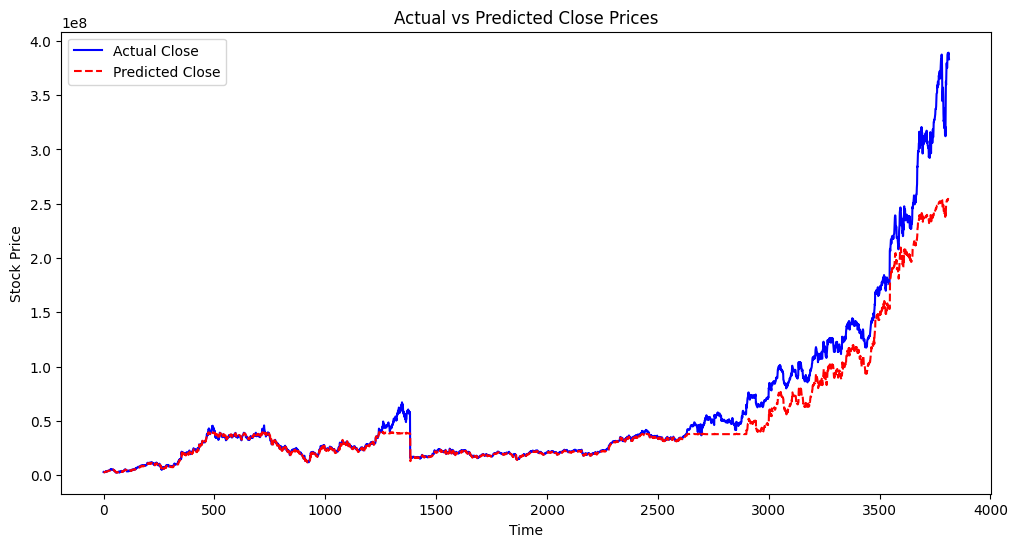

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, LSTM, Conv1D, Add, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score


df = pd.read_csv("/content/drive/MyDrive/Time series/top_10_stock_data.csv")


df['Date'] = pd.to_datetime(df['Date'])


le = LabelEncoder()
df['Scrip_encoded'] = le.fit_transform(df['Ticker'])


features = ['Open', 'High', 'Low', 'Close', 'Volume']
df_features = df[features]

# Handle missing values
df_features.fillna(df_features.median(), inplace=True)

# Normalize
scaler = RobustScaler()
df_scaled = scaler.fit_transform(df_features)
df_scaled = pd.DataFrame(df_scaled, columns=features)

# Attach normalized features + encoded Scrip
df_scaled['Scrip_encoded'] = df['Scrip_encoded'].values

# Sequence creation function (with Scrip)
def create_sequences_with_scrip(data, scrips, seq_length=30):
    X, y, scrip_ids = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # stock features
        y.append(data[i+seq_length, 3])      # target: Close
        scrip_ids.append(scrips[i+seq_length])
    return np.array(X), np.array(y), np.array(scrip_ids)


seq_length = 60
X, y, scrip_input = create_sequences_with_scrip(df_scaled.values, df_scaled['Scrip_encoded'].values, seq_length)


split = int(0.85 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
scrip_train, scrip_test = scrip_input[:split], scrip_input[split:]

# Multi-input model with Embedding
def build_model(input_shape, num_scrips, embedding_dim=8):
    # Stock feature sequence input
    stock_input = Input(shape=input_shape, name="stock_input")

    # Scrip ID input
    scrip_input = Input(shape=(1,), name="scrip_input")
    scrip_embedding = Embedding(input_dim=num_scrips, output_dim=embedding_dim)(scrip_input)
    scrip_embedding = Flatten()(scrip_embedding)
    scrip_embedding = Dense(32, activation="relu")(scrip_embedding)

    # Residual CNN block
    x = Conv1D(64, kernel_size=3, padding="same", activation="relu")(stock_input)
    x = Conv1D(64, kernel_size=3, padding="same", activation="relu")(x)
    shortcut = Conv1D(64, kernel_size=1, padding="same")(stock_input)
    x = Add()([x, shortcut])
    x = BatchNormalization()(x)

    # LSTM
    x = LSTM(64, return_sequences=False)(x)

    # Combine stock features + scrip embedding
    combined = Concatenate()([x, scrip_embedding])
    combined = Dense(128, activation="relu")(combined)
    combined = Dropout(0.3)(combined)
    output = Dense(1, activation="linear")(combined)

    model = Model(inputs=[stock_input, scrip_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), loss="mse", metrics=["mae"])
    return model

# Build and train model
num_scrips = len(le.classes_)
model = build_model(X_train.shape[1:], num_scrips)
history = model.fit(
    {"stock_input": X_train, "scrip_input": scrip_train},
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=({"stock_input": X_test, "scrip_input": scrip_test}, y_test),
    verbose=1
)

# Predict
y_pred = model.predict({"stock_input": X_test, "scrip_input": scrip_test})

# Reverse normalization
y_test_actual = scaler.inverse_transform(np.c_[np.zeros((len(y_test), 4)), y_test])[:, -1]
y_pred_actual = scaler.inverse_transform(np.c_[np.zeros((len(y_pred), 4)), y_pred])[:, -1]

# Metrics
r2 = r2_score(y_test_actual, y_pred_actual)
print(f"R² Score: {r2:.4f}")

# Directional Accuracy
def directional_accuracy(actual, predicted):
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    return np.mean(actual_direction == predicted_direction) * 100

da = directional_accuracy(y_test_actual, y_pred_actual)
print(f"Directional Accuracy: {da:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Close", color="blue")
plt.plot(y_pred_actual, label="Predicted Close", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Close Prices")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100
# Calculate Regression Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Calculate Directional Accuracy
# Ensure both arrays have the same length for comparison
# We take the difference of y_pred and then reshape to a single dimension for compatibility
direction_actual = np.sign(np.diff(y_test))
direction_pred = np.sign(np.diff(y_pred.reshape(-1)))
direction_accuracy = np.mean(direction_actual == direction_pred) * 100

# Print Results
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Directional Accuracy: {direction_accuracy:.2f}%")

MAE: 0.19
MSE: 0.17
RMSE: 0.41
R² Score: 0.9118
Directional Accuracy: 50.20%
